<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Mohammad Mehdi Zare
### Student Number : 98100431
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn , optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from sklearn.metrics import classification_report
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [2]:
device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [3]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=0.1307, std=0.3081),
]) # Write your code here

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [4]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [5]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
batch_size=16
threads_n=2
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True , num_workers=threads_n)
val_loader = torch.utils.data.DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True , num_workers=threads_n)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [6]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
from torch.nn import * 
class ResidualClassifier(nn.Module):
    def __init__(self):
      super(ResidualClassifier, self).__init__()
      self.seq1=Sequential(
        Conv2d(1,16,3,1,1),
        ReLU(inplace=True),
        MaxPool2d(2,2)
      )
      self.seq2=Sequential(
        Conv2d(16,16,3,1,1),
        ReLU(inplace=True),
        Conv2d(16,16,3,1,1),
        ReLU(inplace=True),
      )
      self.seq3=Sequential(
        MaxPool2d(2,2),
        Conv2d(16,64,3,1,1),
        ReLU(inplace=True)
      )
      self.seq4=Sequential(
        Conv2d(64,64,3,1,1),
        ReLU(inplace=True),
        Conv2d(64,64,3,1,1),
        ReLU(inplace=True),
      )

      self.seq5=Sequential(
        AdaptiveAvgPool2d(1),
        Flatten(),
        Linear(64,10),
      )
      


    def forward(self, x):
      res1=self.seq1(x)
      res1_clone=torch.clone(res1)
      res1=res1+self.seq2(res1_clone)
      res2=self.seq3(res1)
      res2=res2+self.seq4(torch.clone(res2))
      return self.seq5(res2)




# Train Model (30 Points)

In [7]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters() , lr=.01)


In [8]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 20
val_losses = []
val_accuracy = []
train_losses = []
train_accuracy = []
trainSteps = len(train_loader.dataset) // batch_size
valSteps = len(val_loader.dataset) // batch_size
for epoch in range(num_epochs):
    model.train()
    
    totalTrainLoss = 0
    totalValLoss = 0
    
    trainCorrect = 0
    valCorrect = 0
    for images, labels in train_loader:  
      images= images.to(device)
      labels= labels.to(device)

      pred= model(images)
      loss=criterion(pred , labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

   
      totalTrainLoss += loss
      trainCorrect += (pred.argmax(1) == labels).type(torch.float).sum().item()
    with torch.no_grad():
        model.eval()
        for images, labels in val_loader:
          images= images.to(device)
          labels= labels.to(device)

          pred= model(images)
          totalValLoss +=criterion(pred , labels)
          valCorrect += (pred.argmax(1) == labels).type(torch.float).sum().item()



    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(train_loader.dataset)
    valCorrect = valCorrect / len(val_loader.dataset)
    # update our training history
    train_losses.append(avgTrainLoss.cpu().detach().numpy())
    train_accuracy.append(trainCorrect)
    val_losses.append(avgValLoss.cpu().detach().numpy())
    val_accuracy.append(valCorrect)
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, num_epochs))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
      avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
      avgValLoss, valCorrect))


[INFO] EPOCH: 1/20
Train loss: 0.481560, Train accuracy: 0.8363
Val loss: 0.237342, Val accuracy: 0.9273

[INFO] EPOCH: 2/20
Train loss: 0.161830, Train accuracy: 0.9499
Val loss: 0.127522, Val accuracy: 0.9609

[INFO] EPOCH: 3/20
Train loss: 0.141734, Train accuracy: 0.9560
Val loss: 0.129078, Val accuracy: 0.9640

[INFO] EPOCH: 4/20
Train loss: 0.136723, Train accuracy: 0.9586
Val loss: 0.122342, Val accuracy: 0.9644

[INFO] EPOCH: 5/20
Train loss: 0.127776, Train accuracy: 0.9620
Val loss: 0.161718, Val accuracy: 0.9549

[INFO] EPOCH: 6/20
Train loss: 0.121879, Train accuracy: 0.9628
Val loss: 0.116462, Val accuracy: 0.9677

[INFO] EPOCH: 7/20
Train loss: 0.118483, Train accuracy: 0.9646
Val loss: 0.110200, Val accuracy: 0.9665

[INFO] EPOCH: 8/20
Train loss: 0.124071, Train accuracy: 0.9627
Val loss: 0.130673, Val accuracy: 0.9605

[INFO] EPOCH: 9/20
Train loss: 0.115406, Train accuracy: 0.9657
Val loss: 0.120659, Val accuracy: 0.9656

[INFO] EPOCH: 10/20
Train loss: 0.110437, Trai

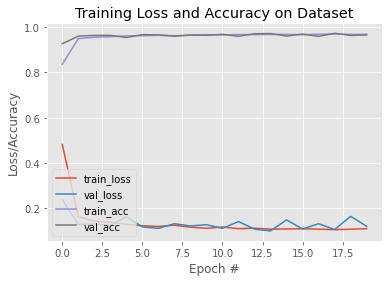

In [9]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
plt.style.use("ggplot")
plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.plot(train_accuracy, label="train_acc")
plt.plot(val_accuracy, label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


# Test Model (20 Points)

10000
              precision    recall  f1-score   support

    0 - zero       0.97      0.99      0.98       980
     1 - one       0.97      0.99      0.98      1135
     2 - two       0.98      0.96      0.97      1032
   3 - three       0.95      0.98      0.96      1010
    4 - four       0.99      0.97      0.98       982
    5 - five       0.98      0.95      0.97       892
     6 - six       0.99      0.96      0.98       958
   7 - seven       0.97      0.95      0.96      1028
   8 - eight       0.93      0.99      0.96       974
    9 - nine       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



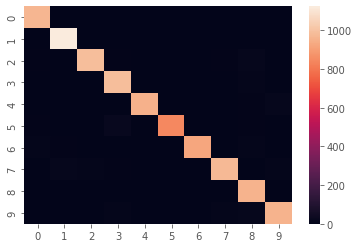

In [16]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))
true_y=np.zeros(0)
pred_y=np.zeros(0)
with torch.no_grad():
  model.eval()
  preds = []
  for (x, y) in test_loader:
    x = x.to(device)
    pred = model(x)
    true_y=np.append(true_y,y.cpu().numpy(),axis=0)
    pred_y=np.append(pred_y,pred.argmax(axis=1).cpu().numpy() , axis=0)
    
    
    
    preds.extend(pred.argmax(axis=1).cpu().numpy())
  print(classification_report(test_data.targets.cpu().numpy(),np.array(preds), target_names=test_data.classes))

import seaborn as sb
conf=np.zeros((10,10))
for i  in range(true_y.size):
    conf[int(true_y[i]),int(pred_y[i])]+=1
sb.heatmap(conf)

